# Grid Search Minimization

This notebook illustrate the steps for a grid search minimization of the output quantile.

#### Libraries

In [1]:
import openturns as ot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

random_state = 123
np.random.seed(random_state)

## Additive model

For the first example we consider an additive model

### The model
This example consider the simple additive example.

In [2]:
from dependence.tests import func_sum
help(func_sum)

Help on function func_sum in module dependence.tests.test_functions:

func_sum(x, a=None)
    Additive weighted model function.
    
    Parameters
    ----------
    x : np.ndarray
        The input values.
    a : np.ndarray
        The input coefficients.
        
    Returns
    -------
        y : a.x^t



### Dimension 2

We consider the problem in dimension $d=2$ and a number of pairs $p=1$ for gaussian margins.

In [3]:
dim = 2
margins = [ot.Normal()]*dim

#### Copula families

We consider a gaussian copula for this first example

In [4]:
families = np.zeros((dim, dim), dtype=int)
families[1, 0] = 1

#### Estimations
We create an instance of the main class for a conservative estimate.

In [5]:
from dependence import ConservativeEstimate

quant_estimate = ConservativeEstimate(model_func=func_sum, margins=margins, families=families)

We aim to minimize the output quantile. To do that, we create a `q_func` object from the function `quantile_func` to associate a probability $\alpha$ to a function that computes the empirical quantile from a given sample.

In [6]:
from dependence import quantile_func
alpha = 0.01
q_func = quantile_func(alpha)

First, we compute the quantile at independence

In [7]:
n = 20000
indep_result = quant_estimate.independence(n_input_sample=n, q_func=q_func, random_state=random_state)

The computation returns a `DependenceResult` instance. This object gather the informations of the computation. It also computes the output quantity of interest (which can also be changed).

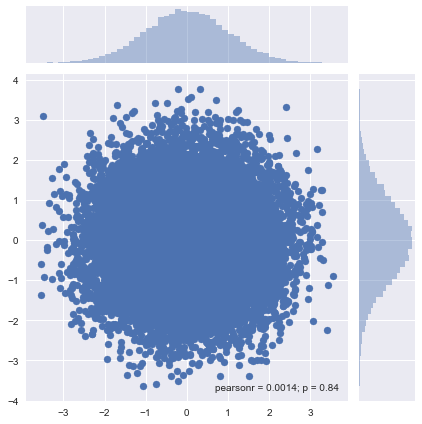

In [8]:
_ = sns.jointplot(indep_result.input_sample[:, 0], indep_result.input_sample[:, 1])

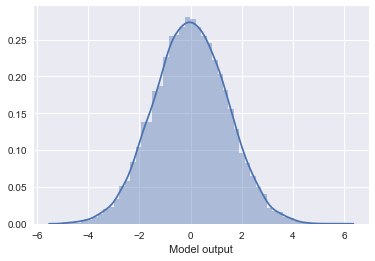

In [9]:
_ = sns.distplot(indep_result.output_sample[:, 0], axlabel='Model output')

In [10]:
print('Output quantile :', indep_result.quantity_)
indep_result.q_func = np.var
print('Output variance :', indep_result.quantity_)

('Output quantile :', -3.322514828206945)
('Output variance :', 2.019283561370207)


A boostrap can be done on the output quantity

In [11]:
indep_result.q_func = q_func
indep_result.compute_bootstrap(n_bootstrap=1000)

And we can plot it

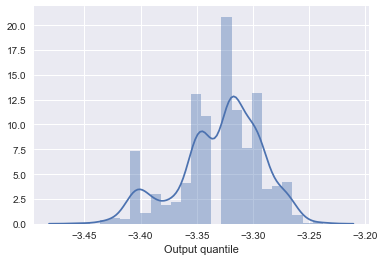

In [12]:
_ = sns.distplot(indep_result.bootstrap_sample[:, 0], axlabel='Output quantile')

In [13]:
boot_std = indep_result.bootstrap_sample.std()
boot_mean = indep_result.bootstrap_sample.mean()
print('Quantile at independence: %.2f with a C.O.V at %.1f %%' % (boot_mean, abs(boot_std/boot_mean)*100.))

Quantile at independence: -3.33 with a C.O.V at 1.1 %


#### Grid Search Approach
Firstly, we consider a grid search approach in order to compare the perfomance with the iterative algorithm.

In [14]:
K = 30
n = 100
grid_type = 'lhs'
grid_result = quant_estimate.gridsearch_minimize(n_dep_param=K, n_input_sample=n, grid_type=grid_type, 
                                                 q_func=q_func, random_state=random_state)

The computation returns a `ListDependenceResult` which is a list of `DependenceResult` instances and some bonuses.

In [15]:
print('The computation did %d model evaluations.' % (grid_result.n_evals))

The computation did 3000 model evaluations.


What is the minimum quantile and what is it's value.

In [16]:
min_result = grid_result.min_result
print('Worst Quantile: %.2f at %.2f' % (min_result.quantity_, min_result.dep_param[0]))

Worst Quantile: -5.17 at 0.76


It can be seen by plotting the results

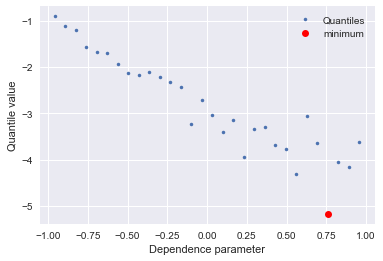

In [17]:
plt.plot(grid_result.dep_params, grid_result.quantities, '.', label='Quantiles')
plt.plot(min_result.dep_param[0], min_result.quantity_, 'ro', label='minimum')
plt.xlabel('Dependence parameter')
plt.ylabel('Quantile value')
plt.legend(loc=0)

In [18]:
grid_result.compute_bootstraps(n_bootstrap=1000)

As for the individual problem, we can do a boostrap also, for each parameters. Because we have $K$ parameters, we can do a bootstrap for the $K$ samples, compute the $K$ quantiles for all the bootstrap and get the minimum quantile for each bootstrap.

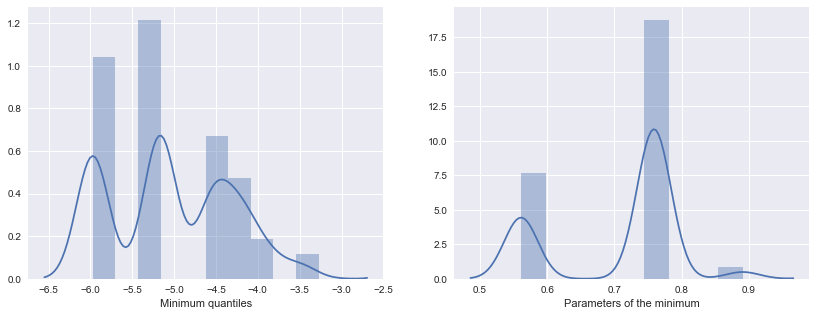

In [19]:
boot_min_quantiles = grid_result.bootstrap_samples.min(axis=0)
boot_argmin_quantiles = grid_result.bootstrap_samples.argmin(axis=0).tolist()
boot_min_params = [grid_result.dep_params[idx][0] for idx in boot_argmin_quantiles]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.distplot(boot_min_quantiles, axlabel="Minimum quantiles", ax=axes[0])
sns.distplot(boot_min_params, axlabel="Parameters of the minimum", ax=axes[1])

For the parameter that have the most occurence for the minimum, we compute its bootstrap mean.

In [20]:
boot_id_min = max(set(boot_argmin_quantiles), key=boot_argmin_quantiles.count)
boot_min_result = grid_result[boot_id_min]

boot_mean = boot_min_result.bootstrap_sample.mean()
boot_std = boot_min_result.bootstrap_sample.std()
print('Worst Quantile: %.2f at %.2f with a C.O.V at %.1f %%' % \
          (boot_mean, min_result.dep_param[0], abs(boot_std/boot_mean)*100.))

Worst Quantile: -4.88 at 0.76 with a C.O.V at 11.8 %


#### With bounds on the dependencies

An interesting option in the `ConservativeEstimate` class is to bound the dependencies, due to some prior informations. 